# RynnBrain Inference Recipes

## Section 10: Manipulate Planning
In this section, we present the ability for RynnBrain in task planning.
User gives the high-level task and RynnBrain outputs low level language command.

### [Setup] Load visualization utils

In [1]:
import os
ROOT_PATH="" # set the path to root dir
assert ROOT_PATH != "", "Please set ROOT_PATH to the cookbooks directory."
os.chdir(ROOT_PATH)

import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPyImage
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sample_video_frames_and_show(video_path, num_samples=32, cols=8, figsize_per_cell=2.2, title="index"):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Can not open video: {video_path}")

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    idxs = np.linspace(0, n_frames - 1, num_samples).round().astype(int)

    frames = []
    valid_idxs = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame_bgr = cap.read()
        if not ok:
            continue
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
        valid_idxs.append(idx)

    cap.release()

    # show
    cols = min(cols, len(frames)) if len(frames) > 0 else cols
    rows = int(np.ceil(len(frames) / cols)) if len(frames) > 0 else 1
    plt.figure(figsize=(cols * figsize_per_cell, rows * figsize_per_cell))

    for i, img in enumerate(frames):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        if title == "index":
            ax.set_title(f"{i}", fontsize=9)
        elif title == "frame_idx":
            ax.set_title(f"{valid_idxs[i]}", fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def add_frame_id(conversation):
  for message in conversation:
    if message["role"] == "user":
        image_idx = 0
        new_contents = []
        for i, content in enumerate(message["content"]):
            if content["type"] == "image":
                    new_contents.append({"type": "text", "text": f"<frame {image_idx}>: "})
                    image_idx += 1
            new_contents.append(content)
        message["content"] = new_contents
  return conversation


def show_images_grid(
    img_dir,
    n=8,
    cols=4,
    figsize_per_cell=(4, 4),
    exts=("png", "jpg", "jpeg", "bmp", "webp"),
    sort=True,
    show_title=True,
    keep_axis=True,
):
    patterns = [os.path.join(img_dir, f"*.{e}") for e in exts]
    paths = []
    for pat in patterns:
        paths.extend(glob.glob(pat))
    if sort:
        paths = sorted(paths)

    paths = paths[:n]
    if len(paths) == 0:
        raise FileNotFoundError(f"No images found in {img_dir} with extensions {exts}")

    rows = (len(paths) + cols - 1) // cols
    fig_w = figsize_per_cell[0] * cols
    fig_h = figsize_per_cell[1] * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)

    for i, ax in enumerate(axes.flat):
        if i < len(paths):
            p = paths[i]
            img = Image.open(p)
            ax.imshow(img)

            if show_title:
                ax.set_title(os.path.basename(p), fontsize=10)

            if keep_axis:
                # ax.set_xlabel("x (px)")
                # ax.set_ylabel("y (px)")
                ax.tick_params(labelsize=8)
            else:
                ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

def convert_bbox(bbox, w, h):
    x1, y1, x2, y2 = bbox_raw
    bbox_norm = [
        int(round(x1 / (w-1) * 1000)),
        int(round(y1 / (h-1) * 1000)),
        int(round(x2 / (w-1) * 1000)),
        int(round(y2 / (h-1) * 1000)),
    ]
    bbox_norm = [max(0, min(1000, v)) for v in bbox_norm]
    return f"({bbox_norm[0]}, {bbox_norm[1]}), ({bbox_norm[2]}, {bbox_norm[3]})"

def draw_bbox_on_image(
    image: Image.Image,
    top_left,
    bottom_right,
    box_color: str = 'lime',
    box_width: int = 5,
    label: str = None,
    label_color: str = 'white'
) -> Image.Image:

    output_image = image.copy().convert("RGB")
    draw = ImageDraw.Draw(output_image)
    
    x_min, y_min = top_left
    x_max, y_max = bottom_right
    bbox = [x_min, y_min, x_max, y_max]
    
    draw.rectangle(bbox, outline=box_color, width=box_width)
    
    if label:
        try:
            font = ImageFont.truetype("arial.ttf", size=max(15, int((x_max - x_min) / 10)))
        except IOError:
            font = ImageFont.load_default()

        if hasattr(draw, 'textbbox'):
             text_bbox = draw.textbbox((x_min, y_min), label, font=font)
             text_width = text_bbox[2] - text_bbox[0]
             text_height = text_bbox[3] - text_bbox[1]
        else: 
             text_width, text_height = draw.textlength(label, font=font)


        label_y0 = max(0, y_min - text_height - 5)
        label_background = [x_min, label_y0, x_min + text_width + 4, y_min]
        draw.rectangle(label_background, fill=box_color)
        
        draw.text((x_min + 2, label_y0), label, fill=label_color, font=font)
    return output_image

def draw_point_on_image(
    image: Image.Image,
    point,
    point_color: str = 'red',
    point_radius: int = 10,
    label: str = None,
    label_color: str = 'red',
    label_size: int = 20 
) -> Image.Image:
    
    output_image = image.copy().convert("RGB")
    
    draw = ImageDraw.Draw(output_image)
    
    x, y = point
    point_bbox = [x - point_radius, y - point_radius, x + point_radius, y + point_radius]
    
    draw.ellipse(point_bbox, fill=point_color, outline=point_color)

    if label:
        text_position = (x + point_radius + 5, y - (label_size / 2)) # y 坐标居中对齐点的中心

        try:
            font = ImageFont.truetype("DejaVuSans.ttf", size=label_size)
        except IOError:
            font = ImageFont.load_default()

        draw.text(
            text_position,      
            label,              
            fill=label_color,   
            font=font           
        )

    return output_image



### [Setup] Load preprocess and postprocess utils

In [2]:
PROMPT = f"""You are a sophisticated dual-arm robot planning the next action for the goal: {{task}}.
    Your output must be a single, structured sentence that embeds perceptual data. This involves selecting the most suitable frame (`n`) for each perception task and providing the corresponding integer coordinates (in the [0, 1000] range). 
    The sentence must follow this precise format: `<affordance>` contains `<frame n>: (x, y)` for the grasp point, `<object>` contains `<frame n>: (x_min, y_min), (x_max, y_max)` for the bounding box, and `<area>` contains `<frame n>: (x, y)` for the target destination point."""

import re

def denormalize_points(point, width, height):
    x_norm, y_norm = point[0], point[1]

    x = round(x_norm / 1000 * width)
    y = round(y_norm / 1000 * height)
    point_list = [x, y]
    return point_list

def parse_complex_response(response_str: str) -> dict:
    outputs_str = response_str

    result = {}

    affordance_pattern = re.compile(r"<affordance>.*?\((\d+),\s*(\d+)\).*?</affordance>", re.DOTALL)
    object_pattern = re.compile(r"<object>.*?\((\d+),\s*(\d+)\),\s*\((\d+),\s*(\d+)\).*?</object>", re.DOTALL)
    area_pattern = re.compile(r"<area>.*?\((\d+),\s*(\d+)\).*?</area>", re.DOTALL)

    affordance_match = affordance_pattern.search(outputs_str)
    object_match = object_pattern.search(outputs_str)
    area_match = area_pattern.search(outputs_str)


    if affordance_match:
        affordance_point = [int(affordance_match.group(1)), int(affordance_match.group(2))]
        result['affordance'] = affordance_point
    if object_match:
        object_points = [
          [int(object_match.group(1)), int(object_match.group(2))],
          [int(object_match.group(3)), int(object_match.group(4))]
        ]
        result['object'] = object_points
    if area_match:
        area_points = [int(area_match.group(1)), int(area_match.group(2))]
        result['area'] = area_points
    
    return result

def visualize_grounding(frame_idx, response_text, image_paths):

    result = parse_complex_response(response_text)

    image_path = image_paths[frame_idx]
    original_image = Image.open(image_path)
    w, h = original_image.size

    final_image = original_image.copy() 
    
    if "affordance" in result:
        points = denormalize_points(result['affordance'], w, h)
        final_image = draw_point_on_image(final_image, points, label='Pick')
    
    if "object" in result:
        points0 = denormalize_points(result['object'][0], w, h)
        points1 = denormalize_points(result['object'][1], w, h)
        final_image = draw_bbox_on_image(final_image, points0, points1, label="object")
        
    if "area" in result:
        points = denormalize_points(result['area'], w, h)
        final_image = draw_point_on_image(final_image, points, point_color='blue', label='Place', label_color="blue")
    
    return final_image

### [General] Load Model and Processor

In [3]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model_path = "Alibaba-DAMO-Academy/RynnBrain-Plan-8B"
model = AutoModelForImageTextToText.from_pretrained(model_path, dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)


/usr/local/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-29 04:00:37.672599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-29 04:00:37.722852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-29 04:00:37.722891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-29 04:00:37.724692: E exte

### Example: Pick and place task planning

1.Load and visualize the video

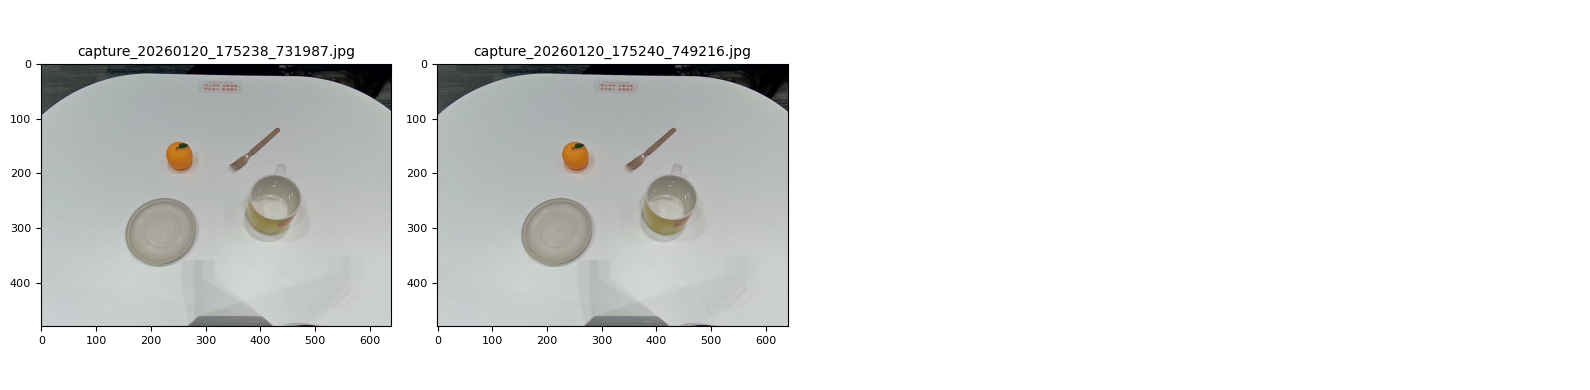

In [4]:
VIDEO_PATH="assets/task_planning/0"
show_images_grid(VIDEO_PATH)

2.Process input images and task

In [5]:
from pathlib import Path
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

task_name = "Place the fork in the mug"

img_paths = sorted(
    [os.path.join(VIDEO_PATH, f) for f in os.listdir(VIDEO_PATH)
     if os.path.splitext(f)[1].lower() in exts]
)
content = [{"type": "text", "text": PROMPT.format(task=task_name)}]
for p in img_paths:
    content.append({"type": "image", "image": str(p)})

w, h = Image.open(img_paths[0]).size


messages = [
    {
        "role": "user",
        "content": content
    }
]
messages = add_frame_id(messages)

print(messages)

[{'role': 'user', 'content': [{'type': 'text', 'text': 'You are a sophisticated dual-arm robot planning the next action for the goal: Place the fork in the mug.\n    Your output must be a single, structured sentence that embeds perceptual data. This involves selecting the most suitable frame (`n`) for each perception task and providing the corresponding integer coordinates (in the [0, 1000] range). \n    The sentence must follow this precise format: `<affordance>` contains `<frame n>: (x, y)` for the grasp point, `<object>` contains `<frame n>: (x_min, y_min), (x_max, y_max)` for the bounding box, and `<area>` contains `<frame n>: (x, y)` for the target destination point.'}, {'type': 'text', 'text': '<frame 0>: '}, {'type': 'image', 'image': 'assets/task_planning/0/capture_20260120_175238_731987.jpg'}, {'type': 'text', 'text': '<frame 1>: '}, {'type': 'image', 'image': 'assets/task_planning/0/capture_20260120_175240_749216.jpg'}]}]


3.Infer with RynnBrain

In [6]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
response = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(response)

Pick up <affordance> <frame 1>: (577, 371) </affordance> of <object> <frame 1>: (541, 248), (680, 414) </object>.


4.Visualize bbox and generate messages



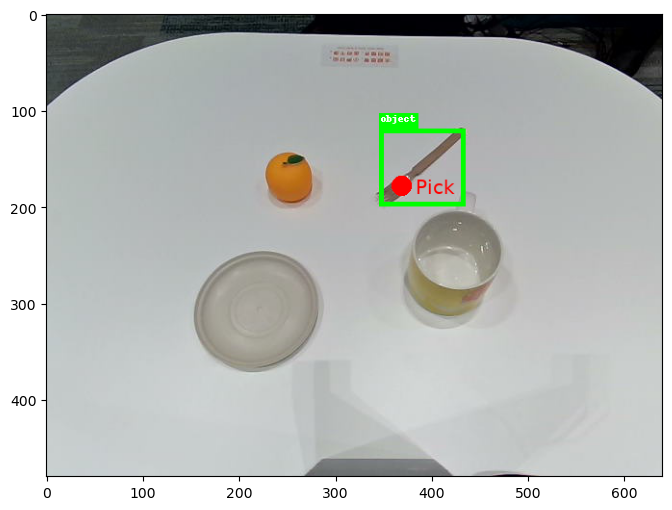

In [7]:
match = list(re.finditer(r"<frame\s*(\d+)>:", response))
total_frame = inputs['image_grid_thw'].shape[0]
if match:
    if 0 <= int(match[-1].group(1)) < total_frame:
        frame_idx = int(match[-1].group(1))  # 提取并转为整数
        # print('Predicted frame idx', frame_idx)
    else:
        frame_idx = total_frame - 1
        # print('Predicted frame out of index, using the last frame', frame_idx)
else:
    frame_idx = total_frame - 1

visualize_img = visualize_grounding(frame_idx, response, img_paths)
plt.figure(figsize=(8, 6)) # 创建一个图像窗口，可以调整大小
plt.imshow(visualize_img)


5.Execute and Predict the next action

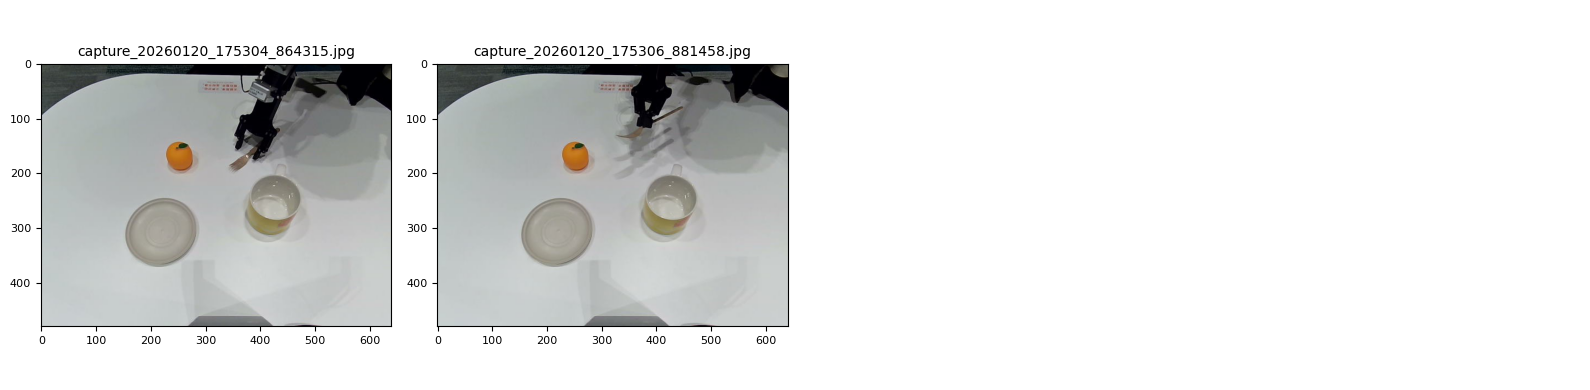

In [8]:
VIDEO_PATH="assets/task_planning/1"
show_images_grid(VIDEO_PATH)

In [9]:

exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

img_paths = sorted(
    [os.path.join(VIDEO_PATH, f) for f in os.listdir(VIDEO_PATH)
     if os.path.splitext(f)[1].lower() in exts]
)
content = []
for p in img_paths:
    content.append({"type": "image", "image": str(p)})

w, h = Image.open(img_paths[0]).size

messages.append(
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": response}
        ]
    }
)

messages_new = [
    {
        "role": "user",
        "content": content
    }
]
messages_new = add_frame_id(messages_new)
messages += messages_new

print(messages)

[{'role': 'user', 'content': [{'type': 'text', 'text': 'You are a sophisticated dual-arm robot planning the next action for the goal: Place the fork in the mug.\n    Your output must be a single, structured sentence that embeds perceptual data. This involves selecting the most suitable frame (`n`) for each perception task and providing the corresponding integer coordinates (in the [0, 1000] range). \n    The sentence must follow this precise format: `<affordance>` contains `<frame n>: (x, y)` for the grasp point, `<object>` contains `<frame n>: (x_min, y_min), (x_max, y_max)` for the bounding box, and `<area>` contains `<frame n>: (x, y)` for the target destination point.'}, {'type': 'text', 'text': '<frame 0>: '}, {'type': 'image', 'image': 'assets/task_planning/0/capture_20260120_175238_731987.jpg'}, {'type': 'text', 'text': '<frame 1>: '}, {'type': 'image', 'image': 'assets/task_planning/0/capture_20260120_175240_749216.jpg'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'te

In [10]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
response = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(response)

Place <object> <frame 1>: (513, 211), (683, 290) </object> into <area> <frame 1>: (667, 579) </area>.


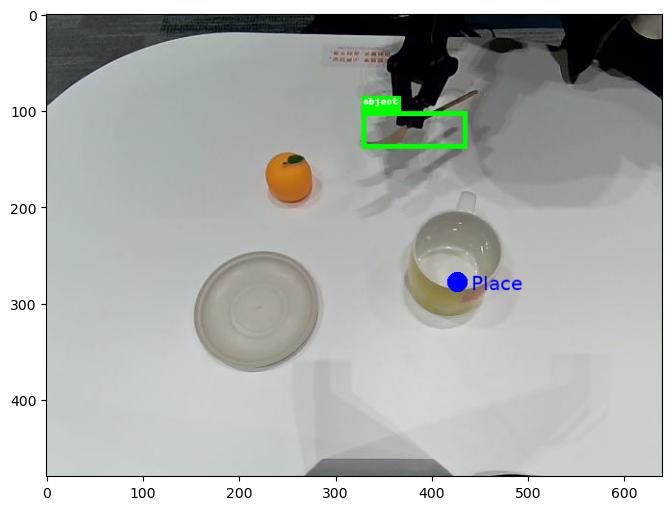

In [11]:
match = list(re.finditer(r"<frame\s*(\d+)>:", response))
total_frame = inputs['image_grid_thw'].shape[0]
if match:
    if 0 <= int(match[-1].group(1)) < total_frame:
        frame_idx = int(match[-1].group(1))  # 提取并转为整数
        # print('Predicted frame idx', frame_idx)
    else:
        frame_idx = total_frame - 1
        # print('Predicted frame out of index, using the last frame', frame_idx)
else:
    frame_idx = total_frame - 1

visualize_img = visualize_grounding(frame_idx, response, img_paths)
plt.figure(figsize=(8, 6)) # 创建一个图像窗口，可以调整大小
plt.imshow(visualize_img)